In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model
from vqVAE import VQVAE

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")

/home/ids/ihamdaoui-21/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def codebook_hist_testset(model, val_loader):
    model.eval()
    hist = torch.zeros(512).to(device)
    with torch.no_grad():
        for batch in val_loader:
            hist += model.codebook_usage(batch.float().to(device))

    return hist

In [3]:

L = 128 # image size L=W
BATCH_SIZE = 16



In [4]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")

test_dataset  = load_dataset(test_set_path)
warnings.filterwarnings("ignore")


NiftiImageIO (0x37032c60): /home/ids/ihamdaoui-21/ACDC/database/testing/patient103/patient103_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x37032c60): /home/ids/ihamdaoui-21/ACDC/database/testing/patient103/patient103_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x370e0250): /home/ids/ihamdaoui-21/ACDC/database/testing/patient103/patient103_frame11_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x370e0250): /home/ids/ihamdaoui-21/ACDC/database/testing/patient103/patient103_frame11_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x370e0250): /home/ids/ihamdaoui-21/ACDC/database/testing/patient109/patient109_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x370e0250): /home/ids/ihamdaoui-21/ACDC/database/testing/patient109/patient109_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x3715bdb0): /home/ids/ihamdaoui-21/ACDC/database/testing/patient109/patient109_frame10_gt.nii.gz has unexpected scales in

In [5]:
input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)

In [6]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 


In [7]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [8]:
vis_batch = next(iter(TestLoader)).to(device)

## Model 100

In [9]:
model_path = 'saved_models/vqvae_100_bestmodel.pth'

model = VQVAE(in_channels, 64, 512)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

In [10]:
def codebook_hist_testset(model, val_loader):
    model.eval()
    hist = torch.zeros(512).to(device)
    with torch.no_grad():
        for batch in val_loader:
            hist += model.codebook_usage(batch.float().to(device))

    return hist

In [11]:
hist = codebook_hist_testset(model, TestLoader).detach().cpu().numpy()
# hist = hist/torch.sum(hist)

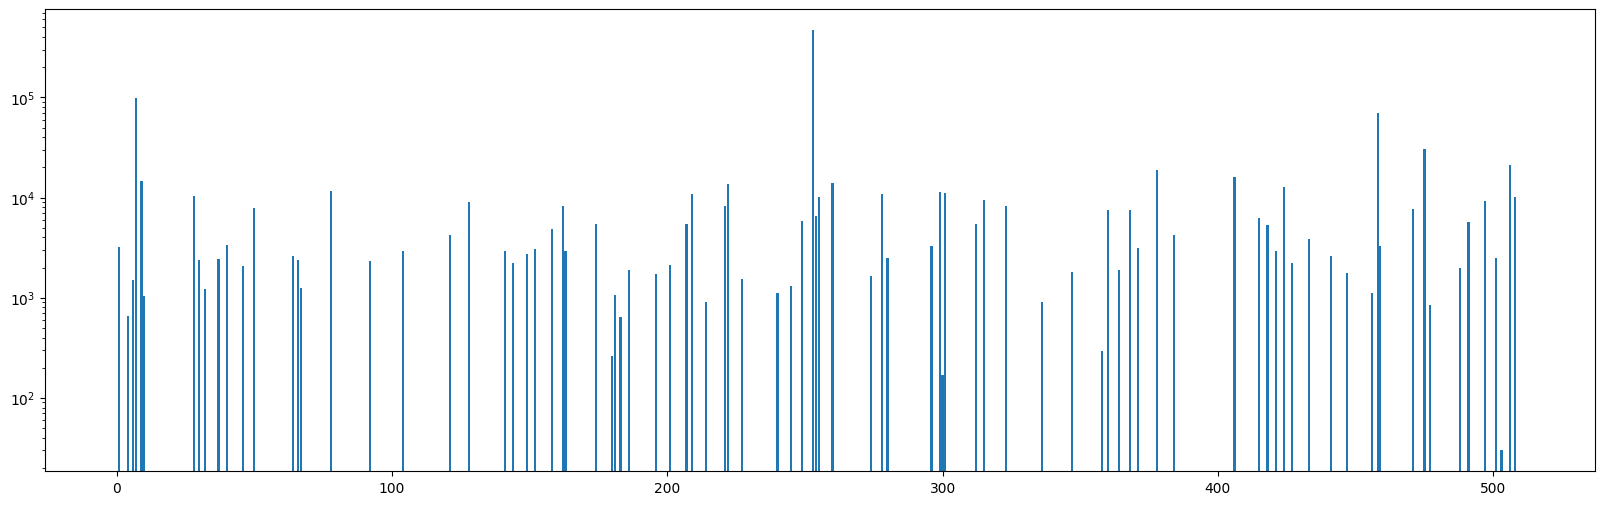

In [12]:
plt.figure(figsize=(20, 6))
plt.bar(range(len(hist)), hist)
plt.yscale('log')

In [13]:
#CodeBook percentage usage 
unused_codes = len(np.where(hist == 0.0)[0])

percentage = (512 - unused_codes)*100/512

print(f" ONLY {512 - unused_codes} OF CODES WERE USED, WHICH MAKE {percentage} % OF CODES FROM THE CODE-BOOK")


 ONLY 89 OF CODES WERE USED, WHICH MAKE 17.3828125 % OF CODES FROM THE CODE-BOOK


In [15]:
import umap
import numpy as np
import matplotlib.pyplot as plt


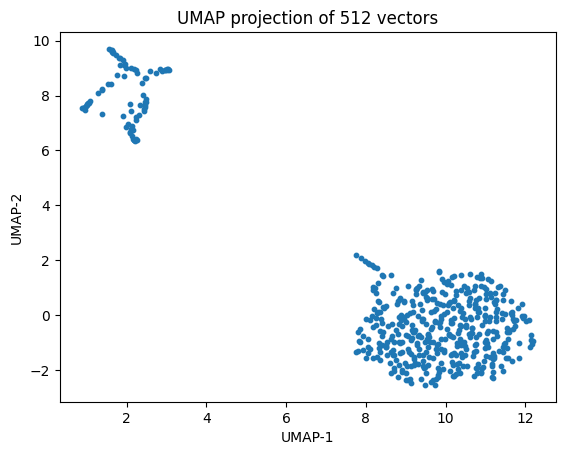

In [41]:
codebook = model.vq_layer.embedding.weight.detach().cpu().numpy()

reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform
embedding = reducer.fit_transform(codebook)

# Plot the result
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, cmap='Spectral')
plt.title('UMAP projection of 512 vectors')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

## Model 101

In [75]:
model_path = 'saved_models/vqvae_101_bestmodel.pth'

model = VQVAE(in_channels, 64, 512)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

In [76]:
hist = codebook_hist_testset(model, TestLoader).detach().cpu().numpy()
# hist = hist/torch.sum(hist)

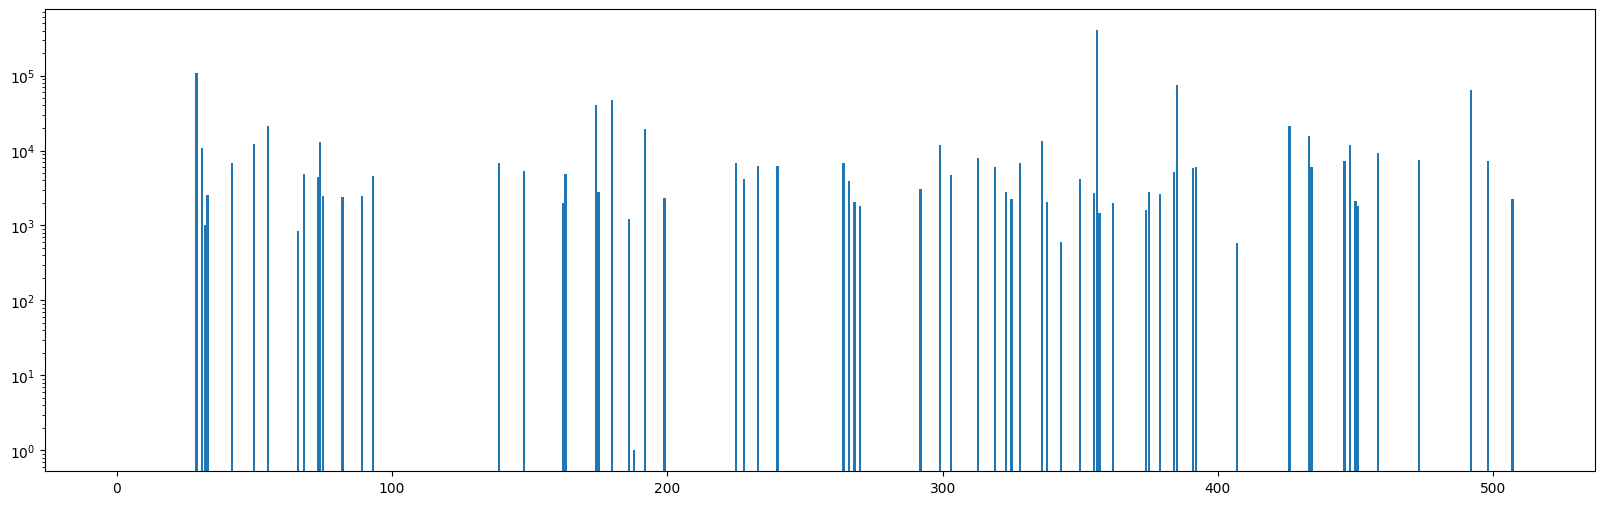

In [77]:
plt.figure(figsize=(20, 6))
plt.bar(range(len(hist)), hist)
plt.yscale('log')

In [79]:
#CodeBook percentage usage 
unused_codes = len(np.where(hist == 0.0)[0])

percentage = (512 - unused_codes)*100/512

print(f" ONLY {512 - unused_codes} OF CODES WERE USED, WHICH MAKE {percentage} % OF CODES FROM THE CODE-BOOK")


 ONLY 70 OF CODES WERE USED, WHICH MAKE 13.671875 % OF CODES FROM THE CODE-BOOK


In [ ]:
codebook = model.vq_layer.embedding.weight.detach().cpu().numpy()

reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform
embedding = reducer.fit_transform(codebook)

# Plot the result
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, cmap='Spectral')
plt.title('UMAP projection of 512 vectors')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

ModuleNotFoundError: No module named 'umap'